In [3]:
import scanpy as sc
import numpy as np

import os

In [1]:
def reprocess(adata):
    adata.layers["clean"] = sc.pp.log1p(
            sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)[
                "X"
            ]
        )
    adata.obsm["clean_pca"] = sc.pp.pca(
            adata.layers["clean"],
            n_comps=300 if adata.shape[0] > 300 else adata.shape[0] - 2,
    )
    adata.obsm["raw_pca"] = sc.pp.pca(
            adata.X,
            n_comps=400 if adata.shape[0] > 400 else adata.shape[0] - 2,
    )
    sc.pp.neighbors(adata, use_rep="clean_pca")
    sc.tl.leiden(adata, key_added="leiden_3", resolution=3.0)
    sc.tl.leiden(adata, key_added="leiden_2", resolution=2.0)
    sc.tl.leiden(adata, key_added="leiden_1", resolution=1.0)
    sc.tl.umap(adata)

    sc.pp.neighbors(adata, use_rep="raw_pca", key_added="raw")
    sc.tl.diffmap(adata, neighbors_key="raw")
    # create a meta group
    adata.obs["dpt_group"] = (
        adata.obs["leiden_1"].astype(str)
        + "_"
        + adata.obs["disease_ontology_term_id"].astype(str)
        + "_"
        + adata.obs["cell_type_ontology_term_id"].astype(str)
        + "_"
        + adata.obs["tissue_ontology_term_id"].astype(str)
    )  # + "_" + adata.obs['dataset_id'].astype(str)

    # if group is too small
    okgroup = [i for i, j in adata.obs["dpt_group"].value_counts().items() if j >= 10]
    not_okgroup = [i for i, j in adata.obs["dpt_group"].value_counts().items() if j < 3]
    # set the group to empty
    adata.obs.loc[adata.obs["dpt_group"].isin(not_okgroup), "dpt_group"] = ""
    adata.obs["heat_diff"] = np.nan
    # for each group
    for val in set(okgroup):
        if val == "":
            continue
        # get the best root cell
        eq = adata.obs.dpt_group == val
        loc = np.where(eq)[0]

        root_ixs = loc[adata.obsm["X_diffmap"][eq, 0].argmin()]
        adata.uns["iroot"] = root_ixs
        # compute the diffusion pseudo time from it
        sc.tl.dpt(adata, neighbors_key="raw")
        adata.obs.loc[eq, "heat_diff"] = adata.obs.loc[eq, "dpt_pseudotime"]
        adata.obs.drop(columns=["dpt_pseudotime"], inplace=True)

    # sort so that the next time points are aligned for all groups
    adata = adata[adata.obs.sort_values(["dpt_group", "heat_diff"]).index]
    return adata

In [4]:
files = os.listdir("/home/ml4ig1/scprint/.lamindb/")

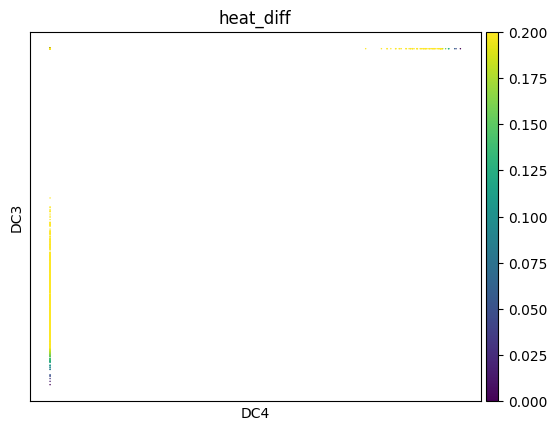

In [15]:
sc.pl.embedding(adata, basis="diffmap", color=['heat_diff'], components=["4,3"], vmax=0.2)

In [21]:
adata.obs[adata.obs.dpt_group.str[0]=="1"].heat_diff.min()

0.0

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


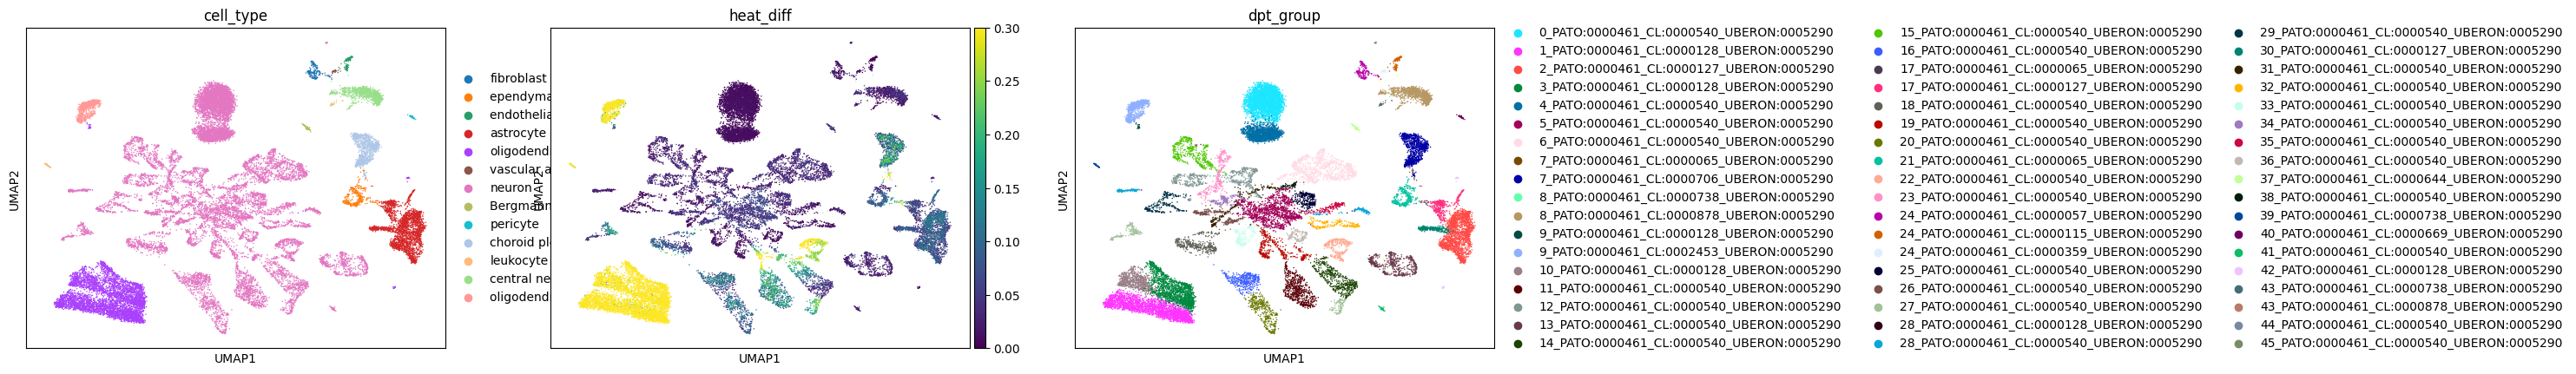

In [17]:
sc.pl.umap(adata, color=["cell_type", "heat_diff", "dpt_group"], vmax=0.3)

In [7]:
from moscot.problems.time import TemporalProblem

In [21]:
adata.var['ensembl_gene_id'] = adata.var.index
adata.var = adata.var.set_index('symbol')
adata.var.index = adata.var.index.astype(str)
adata.var_names_make_unique()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


In [22]:
tp = TemporalProblem(adata)

In [ ]:
if adata.obs['organism_ontology_term_id'].iloc[0] in ['NCBITaxon:9606', "NCBITaxon:10090"]:
    org = "human" if adata.obs['organism_ontology_term_id'].iloc[0] == "NCBITaxon:9606" else "mouse"

In [11]:
org = "human"

In [23]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation=org, gene_set_apoptosis=org
)

In [ ]:
def estimate_marginals(
    adata: AnnData,
    proliferation_key: str = "proliferation",
    apoptosis_key: str = "apoptosis",
    scaling: Optional[float] = None,
):
    def estimate(key: Optional[str], *, fn: Callable[..., ArrayLike], **kwargs: Any) -> ArrayLike:
        if key is None:
            return np.zeros(adata.n_obs, dtype=float)
        try:
            return fn(adata.obs[key].values.astype(float), **kwargs)
        except KeyError:
            raise KeyError(f"Unable to get data from `adata.obs[{key}!r]`.")
        if proliferation_key is None and apoptosis_key is None:
            raise ValueError("At least one of `proliferation_key` or `apoptosis_key` must be specified.")

    if scaling:
        beta_fn = delta_fn = lambda x, *_, **__: x
    else:
        beta_fn, delta_fn = beta, delta
        scaling = 1.0
    birth = estimate(proliferation_key, fn=beta_fn, **kwargs)
    death = estimate(apoptosis_key, fn=delta_fn, **kwargs)

    prior_growth = np.exp((birth - death) * self.delta / scaling)

    scaling = np.sum(prior_growth)
    normalized_growth = prior_growth / scaling
    return scaling, prior_growth, normalized_growth

In [25]:
tp.estimate_marginals()

AttributeError: 'TemporalProblem' object has no attribute 'estimate_marginals'

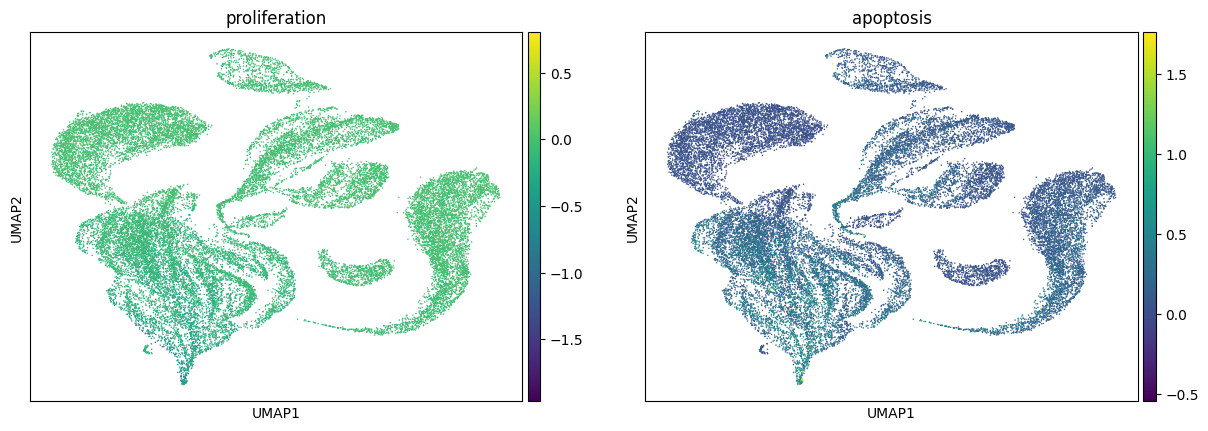

In [24]:
sc.pl.embedding(adata, basis="umap", color=["proliferation", "apoptosis"])

In [5]:
adata = reprocess(sc.read_h5ad("/home/ml4ig1/scprint/.lamindb/"+files[1]))

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [8]:
adata

In [20]:
adata = sc.read_h5ad("/home/ml4ig1/scprint/.lamindb/"+files[1])

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


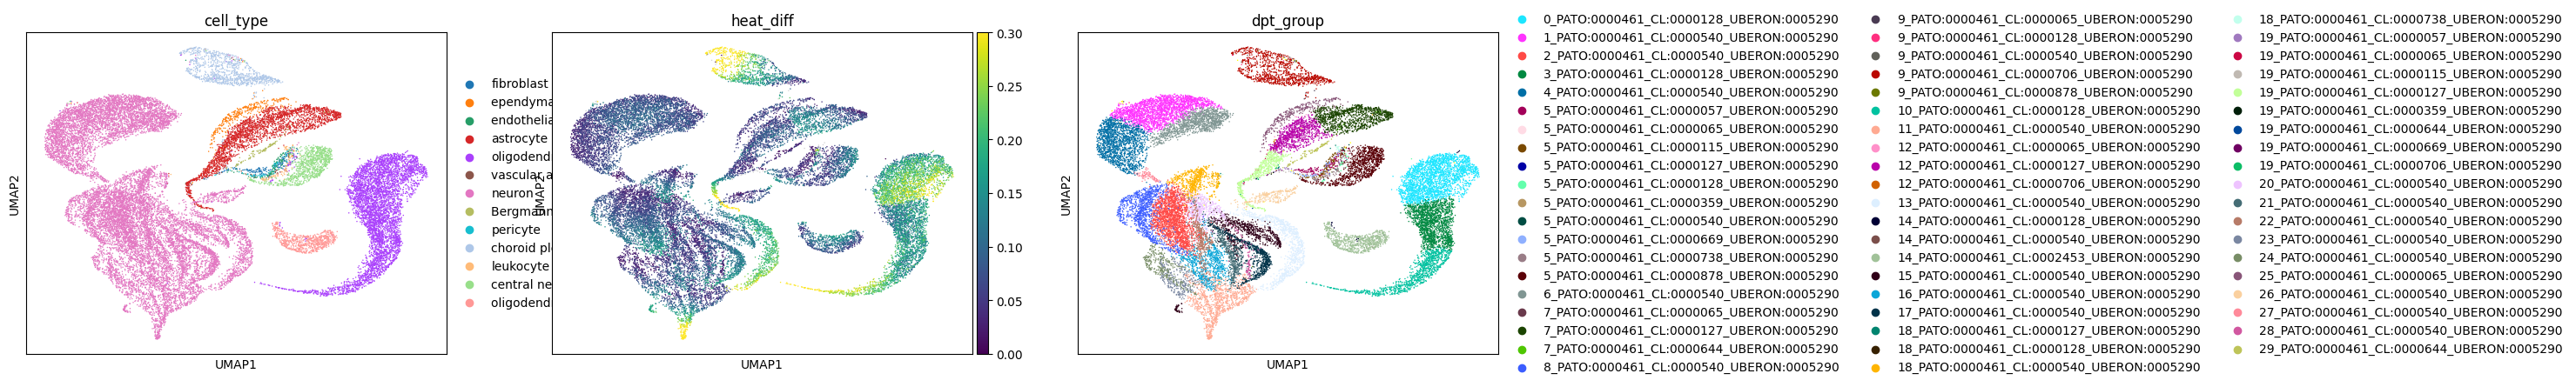

In [4]:
sc.pl.umap(adata, color=["cell_type", "heat_diff", "dpt_group"], vmax=0.3)

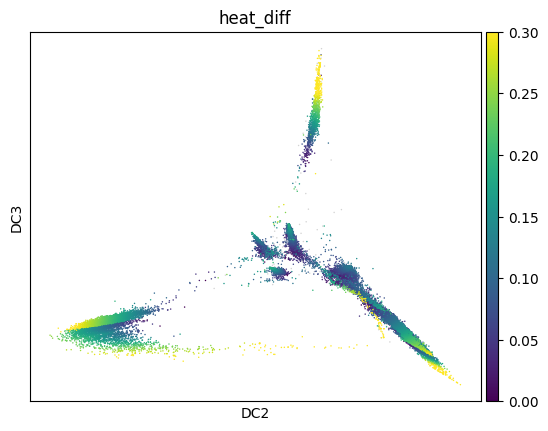

In [7]:
sc.pl.embedding(adata, basis="diffmap", color=['heat_diff'], components=["2,3"], vmax=0.3)

In [ ]:
for f in files:
    adata = reprocess(sc.read_h5ad(f))
    sc.write(f, adata)